## 随机森林

In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer

### 参数
当oob_score=True时，并且当数据量足够大时，大概有30%的袋外数据没有被抽到   
可以采用袋外数据进行评分（而不用使用交叉验证），实际训练中，也不需要划分测试集，直接使用袋外数据作为测试集

In [8]:
# 加载数据
cancer = load_breast_cancer()
print(cancer.data)
print(cancer.target)
print(cancer.data.shape)


[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 

In [19]:
x_train,x_test,y_train,y_test = train_test_split(cancer.data,cancer.target,test_size=0.3)

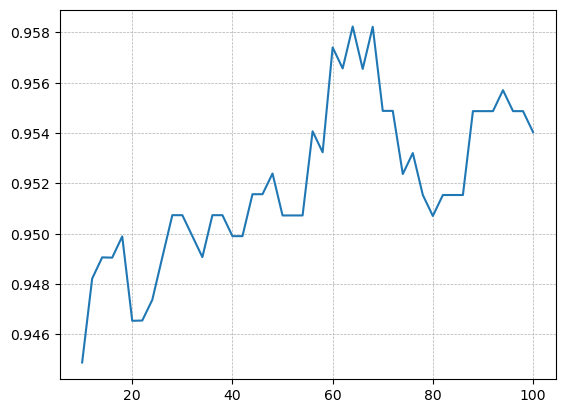

In [23]:
# 单独调试每个参数
scores = []
for i in range(3,101,2):
    # bootstrap默认为True,有放回的均匀抽样
    # 针对数据量不大，三次测试取平均保证足够的数据随机性
    score = 0.0
    for j in (1,22,31):
        rfc = RandomForestClassifier(n_estimators=i, random_state=j, n_jobs=-1 ) #数据量太少，采用交叉验证估分
        score += cross_val_score(rfc, x_train, y_train).mean()
    score = score/3
    scores.append(score)
plt.grid( linestyle = '--', linewidth=0.5)
plt.plot(range(3,101,2), scores)

In [25]:
# 初步测试
score = 0.0
for j in (1,22,31):
    rfc = RandomForestClassifier(n_estimators=63, random_state=j, n_jobs=-1 ) #63个树最佳
    rfc.fit(x_train,y_train)
    score += rfc.score(x_test,y_test)
score = score/3
print(f"accuracy:{score}")

accuracy:0.9629629629629629


In [28]:
# 调单个树的参数
param_grid = {
    'max_depth':[*range(5,100)]
}
grid_search = GridSearchCV(rfc, param_grid=param_grid)
grid_search.fit(x_train,y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

{'max_depth': 6}
0.9574050632911393
RandomForestClassifier(max_depth=6, n_estimators=63, n_jobs=-1, random_state=31)


In [29]:
score = grid_search.best_estimator_.score(x_test,y_test)
print(f"调参后准确率：{score}")

调参后准确率：0.9649122807017544


In [30]:
# 进一步调组合参数
param_grid = {
    'max_depth':[*range(5,10)],
    'min_samples_leaf':[*range(1,11)]
}
grid_search = GridSearchCV(rfc, param_grid=param_grid)
grid_search.fit(x_train,y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
# 发现保持原来参数效果最好

{'max_depth': 6, 'min_samples_leaf': 1}
0.9574050632911393
RandomForestClassifier(max_depth=6, n_estimators=63, n_jobs=-1, random_state=31)


In [31]:
# 最后调一下criterion
param_grid = {
    'criterion':['gini','entropy']
}
grid_search = GridSearchCV(grid_search.best_estimator_, param_grid=param_grid)
grid_search.fit(x_train,y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

# 发现保持原来参数(gini)效果最好

{'criterion': 'gini'}
0.9574050632911393
RandomForestClassifier(max_depth=6, n_estimators=63, n_jobs=-1, random_state=31)


### 补充缺失值

#### 数据集
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

MedInc: 街区组收入中位数  
HouseAge: 街区组房屋年龄中位数  
AveRooms: 每户平均房间数  
AveBedrms: 每户平均卧室数量  
Population: 人口数量  
AveOccup: 家庭成员的平均人数  
Latitude: 纬度  
Longitude: 经度  

#### 思路
特征T不缺失的值对应的其他n-1个特征 + 本来的标签：X_train  
特征T不缺失的值：Y_train  
特征T缺失的值对应的其他n-1个特征 + 本来的标签：X_test  
特征T缺失的值：未知，我们需要预测的Y_test  
这种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用  

从缺失最少的开始进行填补（因为填补缺失最少的特征所需要的准确信息最少）。
填补一个特征时，先将其他特征的缺失值用0（或均值）代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填补下一个特征。每一次填补完毕，有缺失值的特征会减少一个，所以每次循环后，需要用0（或均值）来填补的特征就越来越少。  当进行到最后一个特征时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特征需要用0（或均值）来进行填补了，
而我们已经使用回归为其他特征填补了大量有效信息，可以用来填补缺失最多的特征。
遍历所有的特征后，数据就完整，不再有缺失值



In [401]:
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
#取500个数据
x_full = pd.DataFrame(dataset.data[0:5000])
labels = pd.Series(dataset.target[0:5000])
labels.rename(8, inplace=True)

n_samples = x_full.shape[0]
n_features = x_full.shape[1]
x_missing = x_full.copy()
# x_full

# 制造缺失值
rng = np.random.default_rng(123)
x_miss_col1 = rng.integers(60,2000,1000)
x_miss_col2 = rng.integers(80,3000,1000) 
print(f"{ np.unique(np.array(x_miss_col1)).shape[0] + np.unique(np.array(x_miss_col2)).shape[0]}个缺失值")
x_missing.iloc[x_miss_col1,0] = np.nan
x_missing.iloc[x_miss_col2,1] = np.nan

x_extra_test = dataset.data[5001:10000]
y_extra_test = dataset.target[5001:10000]

x_missing_copy2 = x_missing.copy() # 将填均值处理
x_missing_copy3 = x_missing.copy() # 将填0处理

x_missing[70:90] 

1642个缺失值


,0,1,2,3,4,5,6,7
70,1.7719,26.0,6.047244,1.196850,392.0,3.086614,37.81,-122.29
71,NaN,46.0,3.375451,1.072202,582.0,2.101083,37.81,-122.29
72,NaN,49.0,5.552632,1.342105,560.0,3.684211,37.81,-122.29
73,0.4999,46.0,1.714286,0.571429,18.0,2.571429,37.81,-122.29
74,NaN,20.0,6.278195,1.210526,290.0,2.180451,37.81,-122.29
75,NaN,17.0,2.817768,1.052392,762.0,1.735763,37.81,-122.28
76,NaN,36.0,5.724951,1.104126,1236.0,2.428291,37.81,-122.28
77,1.1111,19.0,5.830918,1.173913,721.0,3.483092,37.81,-122.28
78,NaN,23.0,5.369231,1.150769,1054.0,3.243077,37.81,-122.29
79,2.0114,38.0,4.412903,1.135484,344.0,2.219355,37.80,-122.28


#### 预测缺失值

In [402]:

counts_nan = x_missing.isnull().sum(axis=0)
n_nan = counts_nan[counts_nan>0].shape[0]
sort_indexes = np.argsort(counts_nan).values #从小到大排序后的索引数组
for i in sort_indexes[0-n_nan:]:
    # 对nan填充
    x_data = x_missing.copy()
    y_data = x_data.loc[:,i]
    #拼接标签
    x_data = pd.concat([x_data.loc[:,x_data.columns!=i], pd.DataFrame(labels)], axis=1)
    # 均值填充
    impute_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    x_data.iloc[:,:] = impute_mean.fit_transform(x_data)
    # print(x_data[70:90])
    x_train = x_data[y_data.notnull()].reset_index(drop=True)
    y_train = y_data[y_data.notnull()].reset_index(drop=True)
    x_test = x_data[y_data.isnull()].reset_index(drop=True)
    
    # 训练模型
    rfr = RandomForestRegressor(n_estimators=30, random_state=10, max_depth=30)
    rfr.fit(x_train, y_train)
    y_test = rfr.predict(x_test)
    
    # 对i列的NaN填充
    x_missing.loc[x_missing.loc[:,i].isnull(),i] = y_test
    #print(x_missing[70:90])

rfr_1 = RandomForestRegressor(n_estimators=30, random_state=2, max_depth=30)
rfr_1.fit(x_missing,labels)
score_1 = rfr_1.score(x_extra_test,y_extra_test)
score_1

0.5086351152916389

#### 均值填充

In [403]:

x_missing_copy2 = SimpleImputer(strategy='mean').fit_transform(x_missing_copy2)

rfr_2 = RandomForestRegressor(n_estimators=30, random_state=2, max_depth=30)
rfr_2.fit(x_missing_copy2,labels)
score_2 = rfr_1.score(x_extra_test,y_extra_test)
score_2

0.5086351152916389

In [404]:
pd.DataFrame(x_missing_copy2[70:90]) 

,0,1,2,3,4,5,6,7
0,1.771900,26.0,6.047244,1.196850,392.0,3.086614,37.81,-122.29
1,3.396409,46.0,3.375451,1.072202,582.0,2.101083,37.81,-122.29
2,3.396409,49.0,5.552632,1.342105,560.0,3.684211,37.81,-122.29
3,0.499900,46.0,1.714286,0.571429,18.0,2.571429,37.81,-122.29
4,3.396409,20.0,6.278195,1.210526,290.0,2.180451,37.81,-122.29
5,3.396409,17.0,2.817768,1.052392,762.0,1.735763,37.81,-122.28
6,3.396409,36.0,5.724951,1.104126,1236.0,2.428291,37.81,-122.28
7,1.111100,19.0,5.830918,1.173913,721.0,3.483092,37.81,-122.28
8,3.396409,23.0,5.369231,1.150769,1054.0,3.243077,37.81,-122.29
9,2.011400,38.0,4.412903,1.135484,344.0,2.219355,37.80,-122.28


#### 0填充

In [406]:
x_missing_copy3 = SimpleImputer(strategy='constant', fill_value=0).fit_transform(x_missing_copy3)

rfr_3 = RandomForestRegressor(n_estimators=30, random_state=2, max_depth=30)
rfr_3.fit(x_missing_copy3,labels)
score_3 = rfr_1.score(x_extra_test,y_extra_test)
score_3

0.5086351152916389

In [405]:
pd.DataFrame(x_missing_copy3[70:90])

,0,1,2,3,4,5,6,7
70,1.7719,26.0,6.047244,1.196850,392.0,3.086614,37.81,-122.29
71,NaN,46.0,3.375451,1.072202,582.0,2.101083,37.81,-122.29
72,NaN,49.0,5.552632,1.342105,560.0,3.684211,37.81,-122.29
73,0.4999,46.0,1.714286,0.571429,18.0,2.571429,37.81,-122.29
74,NaN,20.0,6.278195,1.210526,290.0,2.180451,37.81,-122.29
75,NaN,17.0,2.817768,1.052392,762.0,1.735763,37.81,-122.28
76,NaN,36.0,5.724951,1.104126,1236.0,2.428291,37.81,-122.28
77,1.1111,19.0,5.830918,1.173913,721.0,3.483092,37.81,-122.28
78,NaN,23.0,5.369231,1.150769,1054.0,3.243077,37.81,-122.29
79,2.0114,38.0,4.412903,1.135484,344.0,2.219355,37.80,-122.28


#### 完整数据得分

In [410]:
rfr = RandomForestRegressor(n_estimators=30, random_state=2, max_depth=30)
rfr.fit(x_full,labels)
score = rfr.score(x_extra_test,y_extra_test)
score

0.4793084534760145